Note: This notebook uses kipoi-veff which we no longer support. For variant effect prediction please use https://github.com/kipoi/kipoi-veff2. kipoi-veff2 does not support mutation map yet. If you must use kipoi-veff make sure the following are true.
- `model_sources.kipoi.auto_update` is False in `~/.kipoi/config.yaml` 
- `pip install kipoi==0.6.35`
- `git checkout 59b0140` at `model_sources.kipoi.local_path` from `~/.kipoi/config.yaml`. This will ensure your local models repo remains compatible with kipoi-veff. 
- An alternative to above step can be to manually copy the postprocessing tag of your chosen model from [here](https://github.com/kipoi/models/tree/59b0140) to `model_sources.kipoi.local_path/<model>/model(model-template).yml`. For example, if you would like to work with DeepBind, copy [this](https://github.com/kipoi/models/blob/59b0140b1ef1087c51e2ba514ce365700a144ad0/DeepBind/model-template.yaml#L58-L63)  to `model_sources.kipoi.local_path/DeepBind/model-template.yml`.

# Generate a mutation map

This inotebook shall give an simple introduction in how to produce mutation maps for all models that are enabled for variant effect prediction. For variant prediction we Let's use the `DeepSEA/variantEffects` model.


## Variant selection
In this example we will first run the variant effect prediction code that is described in detail in the [`variant_effect_prediction_simple.ipynb`](variant_effect_prediction_simple.ipynb). We will use these effect scores to select variants with the strongest effects to then visualise one of those variants in a mutation map.

In [1]:
# First let's select and setup the model:
import kipoi
model_name = "DeepSEA/variantEffects"
#kipoi.pipeline.install_model_requirements(model_name)
# The input vcf path
vcf_path = "example_data/clinvar_donor_acceptor_chr22.vcf"
# The output vcf path, based on the input file name    
out_vcf_fpath = vcf_path[:-4] + "%s.vcf"%model_name.replace("/", "_")
# The datalaoder keyword arguments
dataloader_arguments = {"fasta_file": "example_data/hg19_chr22.fa"}
# Now actually run the effect prediction using the logit difference:
import kipoi_veff.snv_predict as sp
sp.score_variants(model = model_name,
                  dl_args = dataloader_arguments,
                  scores = ["logit"],
                  input_vcf = vcf_path,
                  output_vcf = out_vcf_fpath)

100%|██████████| 14/14 [00:34<00:00,  2.43s/it]


Just like in the [`variant_effect_prediction_simple.ipynb`](variant_effect_prediction_simple.ipynb) we will now load the results from the generated VCF into a dataframe for easy data access:

In [2]:
from kipoi_veff.parsers import KipoiVCFParser
vcf_reader = KipoiVCFParser("example_data/clinvar_donor_acceptor_chr22DeepSEA_variantEffects.vcf")
import pandas as pd
entries = [el for el in vcf_reader]
entries_df = pd.DataFrame(entries)
entries_df.index = entries_df["variant_id"]

Now we can select a subset of variants that score with the strongest score across the most model output tasks:

In [3]:
# select the 5 variants with the most universal strongest predicted effect in chr22
logit_cols = entries_df.columns.str.contains("LOGIT")
top5_vars = entries_df.loc[:,logit_cols].abs().idxmax().value_counts().head()
top5_vars

12342    305
16376    194
8374     127
22158     65
9970      54
dtype: int64

Now make a subset dataframe:

In [4]:
top5_df = entries_df.loc[entries_df["variant_id"].isin(top5_vars.index)]
top5_df

,variant_id,variant_chr,variant_pos,variant_ref,variant_alt,KV_DeepSEA/variantEffects_LOGIT_8988T_DNase_None_0,KV_DeepSEA/variantEffects_LOGIT_AoSMC_DNase_None_1,KV_DeepSEA/variantEffects_LOGIT_Chorion_DNase_None_2,KV_DeepSEA/variantEffects_LOGIT_CLL_DNase_None_3,KV_DeepSEA/variantEffects_LOGIT_Fibrobl_DNase_None_4,...,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H2AZ_None_910,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K27ac_None_911,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K27me3_None_912,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K36me3_None_913,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K4me1_None_914,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K4me2_None_915,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K4me3_None_916,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K79me2_None_917,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K9me3_None_918,KV_DeepSEA/variantEffects_rID_unnamed_0_0
variant_id,,,,,,,,,,,,,,,,,,,,,
16376,16376,chr22,29108009,G,C,-2.560048,-2.604959,-1.476766,-1.966083,-1.286860,...,0.068821,0.474027,0.227797,0.258411,0.544803,0.144552,0.175402,0.575531,0.055439,chr22:29108009:G:['C']
22158,22158,chr22,29121356,C,G,0.148644,2.256156,0.885380,-0.016387,0.423442,...,0.033477,0.043208,-0.120319,-0.324504,0.189594,0.147367,-0.087590,-0.388921,-0.023764,chr22:29121356:C:['G']
9970,9970,chr22,36701970,G,A,0.504692,1.658696,1.032887,-0.148108,0.914291,...,0.321597,0.299887,0.003522,-0.060838,0.473003,0.342598,0.247115,-0.056063,-0.063615,chr22:36701970:G:['A']
8374,8374,chr22,40750331,A,G,0.571587,0.248589,0.201321,1.890934,0.111852,...,0.421956,-0.020715,-0.156171,-0.151327,0.022475,0.192291,0.189058,-0.144645,-0.187582,chr22:40750331:A:['G']
12342,12342,chr22,50964903,C,G,-1.935331,-2.190516,-1.468465,-1.936842,-1.670801,...,0.236538,0.432350,0.886636,0.113601,0.007765,-0.198594,-0.245576,0.767322,-0.188115,chr22:50964903:C:['G']


Based on that selection let's now generate an input VCF file that can then be used for mutation map calculation:

In [5]:
query_vcf = "example_data/clinvar_donor_acceptor_chr22_5vars.vcf"
variant_order = []
# now subset the VCF:
with open(query_vcf, "w") as ofh:
    with open(vcf_path, "r") as ifh:
        for l in ifh:
            els = l.split("\t")
            if l.startswith("#"):
                ofh.write(l)
            elif els[2] in top5_vars.index.tolist():
                variant_order.append(els[2])
                ofh.write(l)

In [6]:
! cat $query_vcf

##fileformat=VCFv4.0
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=chr1,length=249250621>
##contig=<ID=chr2,length=243199373>
##contig=<ID=chr3,length=198022430>
##contig=<ID=chr4,length=191154276>
##contig=<ID=chr5,length=180915260>
##contig=<ID=chr6,length=171115067>
##contig=<ID=chr7,length=159138663>
##contig=<ID=chr8,length=146364022>
##contig=<ID=chr9,length=141213431>
##contig=<ID=chr10,length=135534747>
##contig=<ID=chr11,length=135006516>
##contig=<ID=chr12,length=133851895>
##contig=<ID=chr13,length=115169878>
##contig=<ID=chr14,length=107349540>
##contig=<ID=chr15,length=102531392>
##contig=<ID=chr16,length=90354753>
##contig=<ID=chr17,length=81195210>
##contig=<ID=chr18,length=78077248>
##contig=<ID=chr19,length=59128983>
##contig=<ID=chr20,length=63025520>
##contig=<ID=chr21,length=48129895>
##contig=<ID=chr22,length=51304566>
##contig=<ID=chrX,length=155270560>
##contig=<ID=chrY,length=59373566>
##contig=<ID=chrMT,length=16569>
#CHROM	POS	ID	REF	ALT	QUA

Now we also want the dataframe to have the same order as the VCF:

In [7]:
top5_df = top5_df.loc[variant_order, :]
top5_df

,variant_id,variant_chr,variant_pos,variant_ref,variant_alt,KV_DeepSEA/variantEffects_LOGIT_8988T_DNase_None_0,KV_DeepSEA/variantEffects_LOGIT_AoSMC_DNase_None_1,KV_DeepSEA/variantEffects_LOGIT_Chorion_DNase_None_2,KV_DeepSEA/variantEffects_LOGIT_CLL_DNase_None_3,KV_DeepSEA/variantEffects_LOGIT_Fibrobl_DNase_None_4,...,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H2AZ_None_910,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K27ac_None_911,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K27me3_None_912,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K36me3_None_913,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K4me1_None_914,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K4me2_None_915,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K4me3_None_916,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K79me2_None_917,KV_DeepSEA/variantEffects_LOGIT_Osteoblasts_H3K9me3_None_918,KV_DeepSEA/variantEffects_rID_unnamed_0_0
variant_id,,,,,,,,,,,,,,,,,,,,,
8374,8374,chr22,40750331,A,G,0.571587,0.248589,0.201321,1.890934,0.111852,...,0.421956,-0.020715,-0.156171,-0.151327,0.022475,0.192291,0.189058,-0.144645,-0.187582,chr22:40750331:A:['G']
9970,9970,chr22,36701970,G,A,0.504692,1.658696,1.032887,-0.148108,0.914291,...,0.321597,0.299887,0.003522,-0.060838,0.473003,0.342598,0.247115,-0.056063,-0.063615,chr22:36701970:G:['A']
12342,12342,chr22,50964903,C,G,-1.935331,-2.190516,-1.468465,-1.936842,-1.670801,...,0.236538,0.432350,0.886636,0.113601,0.007765,-0.198594,-0.245576,0.767322,-0.188115,chr22:50964903:C:['G']
16376,16376,chr22,29108009,G,C,-2.560048,-2.604959,-1.476766,-1.966083,-1.286860,...,0.068821,0.474027,0.227797,0.258411,0.544803,0.144552,0.175402,0.575531,0.055439,chr22:29108009:G:['C']
22158,22158,chr22,29121356,C,G,0.148644,2.256156,0.885380,-0.016387,0.423442,...,0.033477,0.043208,-0.120319,-0.324504,0.189594,0.147367,-0.087590,-0.388921,-0.023764,chr22:29121356:C:['G']


## Calculating the mutation map

Now we are set to generate a mutation map based on a VCF containing variants of interest:

In [8]:
import kipoi
model_name = "DeepSEA/variantEffects"
#kipoi.pipeline.install_model_requirements(model_name)

In [9]:
from kipoi_veff import MutationMap

Set up the mutation map object with the necessary information such as the model and dataloader objects as well as the dataloader arguments to actually perform the calculation

In [10]:
model = kipoi.get_model(model_name)
dataloader = model.default_dataloader
dataloader_arguments = {"fasta_file": "example_data/hg19_chr22.fa"}
mm = MutationMap(model, dataloader, dataloader_args = dataloader_arguments)

Mutation maps can be generated based on a VCF file (`mm.query_vcf`), based on a bed file (`mm.query_bed`) or in the python API also based on a region (`mm.query_region`) that is passed by arguments. Here we will be using the `mm.query_vcf` method:

In [11]:
mmp = mm.query_vcf(query_vcf, scores = ["logit"])

  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.05it/s]
2it [00:01,  1.19it/s]
3it [00:02,  1.24it/s]
4it [00:03,  1.29it/s]
5it [00:03,  1.31it/s]
6it [00:04,  1.33it/s]
7it [00:05,  1.35it/s]
8it [00:05,  1.36it/s]
9it [00:06,  1.37it/s]
10it [00:07,  1.37it/s]
11it [00:07,  1.38it/s]
12it [00:08,  1.38it/s]
13it [00:09,  1.39it/s]
14it [00:10,  1.39it/s]
15it [00:10,  1.40it/s]
16it [00:11,  1.40it/s]
17it [00:12,  1.40it/s]
18it [00:12,  1.40it/s]
19it [00:13,  1.40it/s]
20it [00:14,  1.41it/s]
21it [00:14,  1.41it/s]
22it [00:15,  1.41it/s]
23it [00:16,  1.41it/s]
24it [00:16,  1.41it/s]
25it [00:17,  1.41it/s]
26it [00:18,  1.41it/s]
27it [00:19,  1.42it/s]
28it [00:19,  1.42it/s]
29it [00:20,  1.42it/s]
30it [00:21,  1.42it/s]
31it [00:21,  1.42it/s]
32it [00:22,  1.42it/s]
33it [00:23,  1.42it/s]
34it [00:23,  1.42it/s]
35it [00:24,  1.42it/s]
36it [00:25,  1.42it/s]
37it [00:25,  1.42it/s]
38it [00:26,  1.42it/s]
39it [00:27,  1.42it/s]
40it [00:28,  1.

295it [03:25,  1.44it/s]
296it [03:25,  1.44it/s]
297it [03:26,  1.44it/s]
298it [03:27,  1.44it/s]
299it [03:27,  1.44it/s]
300it [03:28,  1.44it/s]
301it [03:29,  1.44it/s]
302it [03:29,  1.44it/s]
303it [03:30,  1.44it/s]
304it [03:31,  1.44it/s]
305it [03:31,  1.44it/s]
306it [03:32,  1.44it/s]
307it [03:33,  1.44it/s]
308it [03:34,  1.44it/s]
309it [03:34,  1.44it/s]
310it [03:35,  1.44it/s]
311it [03:36,  1.44it/s]
312it [03:36,  1.44it/s]
313it [03:37,  1.44it/s]
314it [03:38,  1.44it/s]
315it [03:38,  1.44it/s]
316it [03:39,  1.44it/s]
317it [03:40,  1.44it/s]
318it [03:40,  1.44it/s]
319it [03:41,  1.44it/s]
320it [03:42,  1.44it/s]
321it [03:43,  1.44it/s]
322it [03:43,  1.44it/s]
323it [03:44,  1.44it/s]
324it [03:45,  1.44it/s]
325it [03:45,  1.44it/s]
326it [03:46,  1.44it/s]
327it [03:47,  1.44it/s]
328it [03:47,  1.44it/s]
329it [03:48,  1.44it/s]
330it [03:49,  1.44it/s]
331it [03:50,  1.44it/s]
332it [03:50,  1.44it/s]
333it [03:51,  1.44it/s]
334it [03:52,  1.44it/s]


587it [06:47,  1.44it/s]
588it [06:48,  1.44it/s]
589it [06:48,  1.44it/s]
590it [06:49,  1.44it/s]
591it [06:50,  1.44it/s]
592it [06:50,  1.44it/s]
593it [06:51,  1.44it/s]
594it [06:52,  1.44it/s]
595it [06:52,  1.44it/s]
596it [06:53,  1.44it/s]
597it [06:54,  1.44it/s]
598it [06:54,  1.44it/s]
599it [06:55,  1.44it/s]
600it [06:56,  1.44it/s]
601it [06:57,  1.44it/s]
602it [06:57,  1.44it/s]
603it [06:58,  1.44it/s]
604it [06:59,  1.44it/s]
605it [06:59,  1.44it/s]
606it [07:00,  1.44it/s]
607it [07:01,  1.44it/s]
608it [07:01,  1.44it/s]
609it [07:02,  1.44it/s]
610it [07:03,  1.44it/s]
611it [07:04,  1.44it/s]
612it [07:04,  1.44it/s]
613it [07:05,  1.44it/s]
614it [07:06,  1.44it/s]
615it [07:06,  1.44it/s]
616it [07:07,  1.44it/s]
617it [07:08,  1.44it/s]
618it [07:08,  1.44it/s]
619it [07:09,  1.44it/s]
620it [07:10,  1.44it/s]
621it [07:11,  1.44it/s]
622it [07:11,  1.44it/s]
623it [07:12,  1.44it/s]
624it [07:13,  1.44it/s]
625it [07:13,  1.44it/s]
626it [07:14,  1.44it/s]


879it [10:09,  1.44it/s]
880it [10:10,  1.44it/s]
881it [10:11,  1.44it/s]
882it [10:12,  1.44it/s]
883it [10:12,  1.44it/s]
884it [10:13,  1.44it/s]
885it [10:14,  1.44it/s]
886it [10:14,  1.44it/s]
887it [10:15,  1.44it/s]
888it [10:16,  1.44it/s]
889it [10:16,  1.44it/s]
890it [10:17,  1.44it/s]
891it [10:18,  1.44it/s]
892it [10:19,  1.44it/s]
893it [10:19,  1.44it/s]
894it [10:20,  1.44it/s]
895it [10:21,  1.44it/s]
896it [10:21,  1.44it/s]
897it [10:22,  1.44it/s]
898it [10:23,  1.44it/s]
899it [10:23,  1.44it/s]
900it [10:24,  1.44it/s]
901it [10:25,  1.44it/s]
902it [10:26,  1.44it/s]
903it [10:26,  1.44it/s]
904it [10:27,  1.44it/s]
905it [10:28,  1.44it/s]
906it [10:28,  1.44it/s]
907it [10:29,  1.44it/s]
908it [10:30,  1.44it/s]
909it [10:30,  1.44it/s]
910it [10:31,  1.44it/s]
911it [10:32,  1.44it/s]
912it [10:32,  1.44it/s]
913it [10:33,  1.44it/s]
914it [10:34,  1.44it/s]
915it [10:35,  1.44it/s]
916it [10:35,  1.44it/s]
917it [10:36,  1.44it/s]
918it [10:37,  1.44it/s]


1165it [13:28,  1.44it/s]
1166it [13:29,  1.44it/s]
1167it [13:30,  1.44it/s]
1168it [13:30,  1.44it/s]
1169it [13:31,  1.44it/s]
1170it [13:32,  1.44it/s]
1171it [13:32,  1.44it/s]
1172it [13:33,  1.44it/s]
1173it [13:34,  1.44it/s]
1174it [13:35,  1.44it/s]
1175it [13:35,  1.44it/s]
1176it [13:36,  1.44it/s]
1177it [13:37,  1.44it/s]
1178it [13:37,  1.44it/s]
1179it [13:38,  1.44it/s]
1180it [13:39,  1.44it/s]
1181it [13:39,  1.44it/s]
1182it [13:40,  1.44it/s]
1183it [13:41,  1.44it/s]
1184it [13:42,  1.44it/s]
1185it [13:42,  1.44it/s]
1186it [13:43,  1.44it/s]
1187it [13:44,  1.44it/s]
1188it [13:44,  1.44it/s]
1189it [13:45,  1.44it/s]
1190it [13:46,  1.44it/s]
1191it [13:46,  1.44it/s]
1192it [13:47,  1.44it/s]
1193it [13:48,  1.44it/s]
1194it [13:49,  1.44it/s]
1195it [13:49,  1.44it/s]
1196it [13:50,  1.44it/s]
1197it [13:51,  1.44it/s]
1198it [13:51,  1.44it/s]
1199it [13:52,  1.44it/s]
1200it [13:53,  1.44it/s]
1201it [13:53,  1.44it/s]
1202it [13:54,  1.44it/s]
1203it [13:5

1447it [16:44,  1.44it/s]
1448it [16:45,  1.44it/s]
1449it [16:46,  1.44it/s]
1450it [16:47,  1.44it/s]
1451it [16:47,  1.44it/s]
1452it [16:48,  1.44it/s]
1453it [16:49,  1.44it/s]
1454it [16:49,  1.44it/s]
1455it [16:50,  1.44it/s]
1456it [16:51,  1.44it/s]
1457it [16:51,  1.44it/s]
1458it [16:52,  1.44it/s]
1459it [16:53,  1.44it/s]
1460it [16:53,  1.44it/s]
1461it [16:54,  1.44it/s]
1462it [16:55,  1.44it/s]
1463it [16:56,  1.44it/s]
1464it [16:56,  1.44it/s]
1465it [16:57,  1.44it/s]
1466it [16:58,  1.44it/s]
1467it [16:58,  1.44it/s]
1468it [16:59,  1.44it/s]
1469it [17:00,  1.44it/s]
1470it [17:00,  1.44it/s]
1471it [17:01,  1.44it/s]
1472it [17:02,  1.44it/s]
1473it [17:02,  1.44it/s]
1474it [17:03,  1.44it/s]
1475it [17:04,  1.44it/s]
1476it [17:05,  1.44it/s]
1477it [17:05,  1.44it/s]
1478it [17:06,  1.44it/s]
1479it [17:07,  1.44it/s]
1480it [17:07,  1.44it/s]
1481it [17:08,  1.44it/s]
1482it [17:09,  1.44it/s]
1483it [17:09,  1.44it/s]
1484it [17:10,  1.44it/s]
1485it [17:1

1729it [20:01,  1.44it/s]
1730it [20:01,  1.44it/s]
1731it [20:02,  1.44it/s]
1732it [20:03,  1.44it/s]
1733it [20:04,  1.44it/s]
1734it [20:04,  1.44it/s]
1735it [20:05,  1.44it/s]
1736it [20:06,  1.44it/s]
1737it [20:06,  1.44it/s]
1738it [20:07,  1.44it/s]
1739it [20:08,  1.44it/s]
1740it [20:08,  1.44it/s]
1741it [20:09,  1.44it/s]
1742it [20:10,  1.44it/s]
1743it [20:11,  1.44it/s]
1744it [20:11,  1.44it/s]
1745it [20:12,  1.44it/s]
1746it [20:13,  1.44it/s]
1747it [20:13,  1.44it/s]
1748it [20:14,  1.44it/s]
1749it [20:15,  1.44it/s]
1750it [20:15,  1.44it/s]
1751it [20:16,  1.44it/s]
1752it [20:17,  1.44it/s]
1753it [20:18,  1.44it/s]
1754it [20:18,  1.44it/s]
1755it [20:19,  1.44it/s]
1756it [20:20,  1.44it/s]
1757it [20:20,  1.44it/s]
1758it [20:21,  1.44it/s]
1759it [20:22,  1.44it/s]
1760it [20:22,  1.44it/s]
1761it [20:23,  1.44it/s]
1762it [20:24,  1.44it/s]
1763it [20:25,  1.44it/s]
1764it [20:25,  1.44it/s]
1765it [20:26,  1.44it/s]
1766it [20:27,  1.44it/s]
1767it [20:2

The object returned by `mm.query_*` methods are `MutationMapPlotter` objects that can either be stored in a hdf5 file or be used for plotting using their `plot_mutmap` method.

The data in the `MutationMapPlotter` is stored hierarchically by:

- Line of the query input (file), which is an integer number. For bed files the index is for regions of length of the model input that overlapped the regions defined in the region definition bed file.
- The name of the model (DNA sequence) input with regard to which the effect predictions were calculated.
- The scoring function defined by the `score` argument
- The model output task for which the effect prediction was calculated

Therefore also for plotting one must select the dataset that should be plotted. Here we will select the fourth variant in the VCF (id: 16376) and the model task which had the strongest absolute predicted effect in our initial variant selection.

In [12]:
# Fourth variant in the VCF
sel_line = 3
# Select the model output being affected the most by this variant:
model_task = top5_df.loc[:,logit_cols].iloc[sel_line].abs().idxmax().split("_LOGIT_")[1]
model_task

'SK-N-SH_RA_CTCF_None_385'

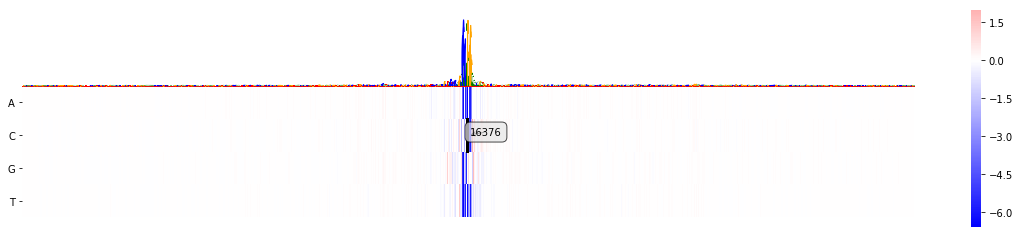

In [14]:
mmp.plot_mutmap(sel_line, "seq", "logit", model_task)

As we can see we can't see much. Everything is a bit squished, but the variant is already annotated with the ID that was given in the VCF file: 16376.

By default the full input sequence length is displayed, which is 1000bp for the DeepSEA model. In order to zoom in let's find the variant position and then zoom down to a 80bp window surrounding the variant:

In [15]:
var_pos = top5_df["variant_pos"].iloc[sel_line]
var_pos

29108009

In order to zoom in one can use the `limit_region_genomic` argument which accepts a tuple of two values - start and end of the genomic region (0-based) which should be selected for plotting.

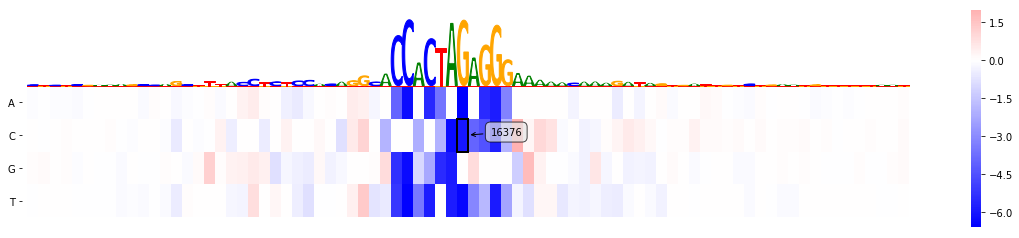

In [16]:
mmp.plot_mutmap(sel_line, "seq", "logit", model_task, limit_region_genomic=(var_pos -40, var_pos+40))

Now since we are looking at CTCF track one might suspect that the variant lies in a CTCF binding motif, but it is somewhat not 100% clear. Let's see whether a motif on the reverse strand is actually affected:

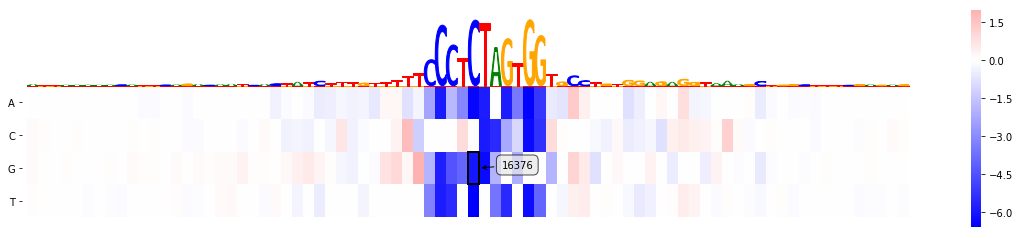

In [17]:
mmp.plot_mutmap(sel_line, "seq", "logit", model_task, limit_region_genomic=(var_pos -40, var_pos+40), rc_plot=True)

## Add additional annotation (dbSNP)

Now that we know how to zoom and reverse-complement mutation maps let's also try and highlight further variants in the region. For that I have prepared a subset of variants of the dbSNP b151 GRCh37 `All_20180423.vcf.gz` in the proximity of the selected variant. We can use this VCF to highlight dbSNP variants in the region.

Let's first get the variant information into the right format:

In [18]:
import cyvcf2
vcf_obj = cyvcf2.VCF("example_data/dbsnp_chr22_29108009.vcf")
variants = {"chr":[], "pos":[], "id":[], "ref":[], "alt":[]}
for rec in vcf_obj:
    # skip indels
    if rec.is_indel:
        continue
    variants["chr"].append(rec.CHROM)
    variants["pos"].append(rec.POS)
    variants["id"].append(rec.ID)
    variants["ref"].append(rec.REF)
    variants["alt"].append(rec.ALT[0])

Now we can plug this dictionary into the plotting method and take a look at our annotated plot.

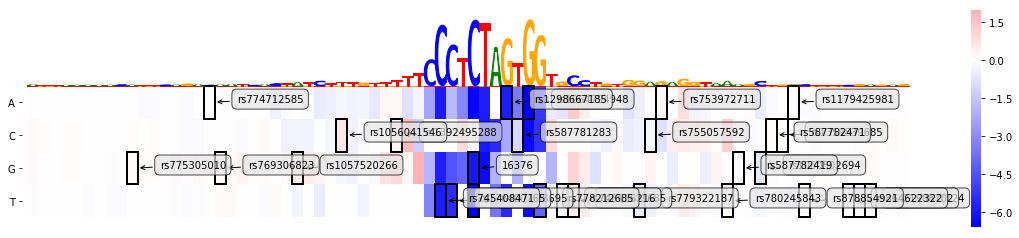

In [19]:
mmp.plot_mutmap(sel_line, "seq", "logit", model_task, limit_region_genomic=(var_pos -40, var_pos+40),
                rc_plot=True, annotation_variants = variants)

Arguably it's not the most beautiful plot as labels start overlapping, so let's remove them and let's also exclude out seed variant, in order to highlight the difference we might actually also want to change the colour of the variant boxes to red:

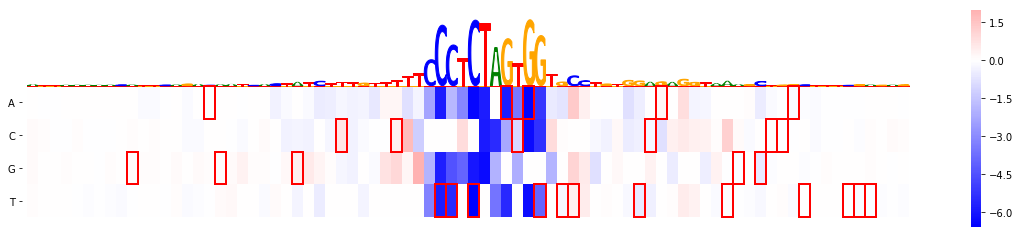

In [20]:
mmp.plot_mutmap(sel_line, "seq", "logit", model_task, limit_region_genomic=(var_pos -40, var_pos+40),
                rc_plot=True, annotation_variants = variants, show_var_id=False,
                ignore_stored_var_annotation=True,var_box_color="red", )

# The CLI

Mutation maps can be calculated using the command line interface analogously to the way presented above for the python API. Let's therefore collect all the input and output file names:

In [21]:
import json
model_name = "DeepSEA/variantEffects"
dataloader_arguments_str = "'%s'"%json.dumps({"fasta_file": "example_data/hg19_chr22.fa"})
query_vcf = "example_data/clinvar_donor_acceptor_chr22_5vars.vcf"
output_file = "example_data/clinvar_donor_acceptor_chr22_5vars_mutmap.hdf5"

Now we are ready to calculate the mutation map data:

In [22]:
! kipoi veff create_mutation_map $model_name --dataloader_args $dataloader_arguments_str \
   --scores logit --output $output_file --regions_file $query_vcf

WARNING [kipoi.__main__] `kipoi postproc` has been deprecated. Please use kipoi <plugin> ...: 
    # - plugin commands:
    veff             Variant effect prediction
    interpret        Model interpretation using feature importance scores like ISM, grad*input or DeepLIFT.

INFO [kipoi.sources] Update /nfs/research1/stegle/users/rkreuzhu/.kipoi/models/
Already up-to-date.
INFO [kipoi.sources] git-lfs pull -I DeepSEA/variantEffects/**
INFO [kipoi.sources] git-lfs pull -I DeepSEA/template/**
INFO [kipoi.sources] git-lfs pull -I DeepSEA/template/example_files/**
INFO [kipoi.sources] git-lfs pull -I DeepSEA/template/model_files/**
INFO [kipoi.sources] model DeepSEA/variantEffects loaded
INFO [kipoi.sources] git-lfs pull -I DeepSEA/variantEffects/./**
INFO [kipoi.sources] git-lfs pull -I DeepSEA/template/**
INFO [kipoi.sources] git-lfs pull -I DeepSEA/template/example_files/**
INFO [kipoi.sources] git-lfs pull -I DeepSEA/template/model_files/**
INFO [kipoi.sources] dataloader DeepSEA/varia

237it [02:52,  1.38it/s]
238it [02:53,  1.38it/s]
239it [02:53,  1.38it/s]
240it [02:54,  1.38it/s]
241it [02:55,  1.38it/s]
242it [02:55,  1.38it/s]
243it [02:56,  1.38it/s]
244it [02:57,  1.38it/s]
245it [02:58,  1.38it/s]
246it [02:58,  1.38it/s]
247it [02:59,  1.38it/s]
248it [03:00,  1.38it/s]
249it [03:01,  1.38it/s]
250it [03:01,  1.38it/s]
251it [03:02,  1.38it/s]
252it [03:03,  1.38it/s]
253it [03:03,  1.38it/s]
254it [03:04,  1.38it/s]
255it [03:05,  1.38it/s]
256it [03:06,  1.38it/s]
257it [03:06,  1.38it/s]
258it [03:07,  1.38it/s]
259it [03:08,  1.38it/s]
260it [03:09,  1.38it/s]
261it [03:09,  1.38it/s]
262it [03:10,  1.38it/s]
263it [03:11,  1.38it/s]
264it [03:11,  1.38it/s]
265it [03:12,  1.38it/s]
266it [03:13,  1.38it/s]
267it [03:14,  1.37it/s]
268it [03:14,  1.37it/s]
269it [03:15,  1.37it/s]
270it [03:16,  1.37it/s]
271it [03:17,  1.37it/s]
272it [03:17,  1.37it/s]
273it [03:18,  1.37it/s]
274it [03:19,  1.37it/s]
275it [03:20,  1.37it/s]
276it [03:20,  1.37it/s]


529it [06:25,  1.37it/s]
530it [06:25,  1.37it/s]
531it [06:26,  1.37it/s]
532it [06:27,  1.37it/s]
533it [06:28,  1.37it/s]
534it [06:28,  1.37it/s]
535it [06:29,  1.37it/s]
536it [06:30,  1.37it/s]
537it [06:30,  1.37it/s]
538it [06:31,  1.37it/s]
539it [06:32,  1.37it/s]
540it [06:33,  1.37it/s]
541it [06:33,  1.37it/s]
542it [06:34,  1.37it/s]
543it [06:35,  1.37it/s]
544it [06:36,  1.37it/s]
545it [06:36,  1.37it/s]
546it [06:37,  1.37it/s]
547it [06:38,  1.37it/s]
548it [06:38,  1.37it/s]
549it [06:39,  1.37it/s]
550it [06:40,  1.37it/s]
551it [06:41,  1.37it/s]
552it [06:41,  1.37it/s]
553it [06:42,  1.37it/s]
554it [06:43,  1.37it/s]
555it [06:44,  1.37it/s]
556it [06:44,  1.37it/s]
557it [06:45,  1.37it/s]
558it [06:46,  1.37it/s]
559it [06:47,  1.37it/s]
560it [06:47,  1.37it/s]
561it [06:48,  1.37it/s]
562it [06:49,  1.37it/s]
563it [06:49,  1.37it/s]
564it [06:50,  1.37it/s]
565it [06:51,  1.37it/s]
566it [06:52,  1.37it/s]
567it [06:52,  1.37it/s]
568it [06:53,  1.37it/s]


821it [09:58,  1.37it/s]
822it [09:59,  1.37it/s]
823it [10:00,  1.37it/s]
824it [10:00,  1.37it/s]
825it [10:01,  1.37it/s]
826it [10:02,  1.37it/s]
827it [10:03,  1.37it/s]
828it [10:03,  1.37it/s]
829it [10:04,  1.37it/s]
830it [10:05,  1.37it/s]
831it [10:06,  1.37it/s]
832it [10:06,  1.37it/s]
833it [10:07,  1.37it/s]
834it [10:08,  1.37it/s]
835it [10:08,  1.37it/s]
836it [10:09,  1.37it/s]
837it [10:10,  1.37it/s]
838it [10:11,  1.37it/s]
839it [10:11,  1.37it/s]
840it [10:12,  1.37it/s]
841it [10:13,  1.37it/s]
842it [10:14,  1.37it/s]
843it [10:14,  1.37it/s]
844it [10:15,  1.37it/s]
845it [10:16,  1.37it/s]
846it [10:16,  1.37it/s]
847it [10:17,  1.37it/s]
848it [10:18,  1.37it/s]
849it [10:19,  1.37it/s]
850it [10:19,  1.37it/s]
851it [10:20,  1.37it/s]
852it [10:21,  1.37it/s]
853it [10:22,  1.37it/s]
854it [10:22,  1.37it/s]
855it [10:23,  1.37it/s]
856it [10:24,  1.37it/s]
857it [10:25,  1.37it/s]
858it [10:25,  1.37it/s]
859it [10:26,  1.37it/s]
860it [10:27,  1.37it/s]


1109it [13:29,  1.37it/s]
1110it [13:30,  1.37it/s]
1111it [13:31,  1.37it/s]
1112it [13:31,  1.37it/s]
1113it [13:32,  1.37it/s]
1114it [13:33,  1.37it/s]
1115it [13:34,  1.37it/s]
1116it [13:34,  1.37it/s]
1117it [13:35,  1.37it/s]
1118it [13:36,  1.37it/s]
1119it [13:37,  1.37it/s]
1120it [13:37,  1.37it/s]
1121it [13:38,  1.37it/s]
1122it [13:39,  1.37it/s]
1123it [13:40,  1.37it/s]
1124it [13:40,  1.37it/s]
1125it [13:41,  1.37it/s]
1126it [13:42,  1.37it/s]
1127it [13:42,  1.37it/s]
1128it [13:43,  1.37it/s]
1129it [13:44,  1.37it/s]
1130it [13:45,  1.37it/s]
1131it [13:45,  1.37it/s]
1132it [13:46,  1.37it/s]
1133it [13:47,  1.37it/s]
1134it [13:48,  1.37it/s]
1135it [13:48,  1.37it/s]
1136it [13:49,  1.37it/s]
1137it [13:50,  1.37it/s]
1138it [13:50,  1.37it/s]
1139it [13:51,  1.37it/s]
1140it [13:52,  1.37it/s]
1141it [13:53,  1.37it/s]
1142it [13:53,  1.37it/s]
1143it [13:54,  1.37it/s]
1144it [13:55,  1.37it/s]
1145it [13:56,  1.37it/s]
1146it [13:56,  1.37it/s]
1147it [13:5

1391it [16:56,  1.37it/s]
1392it [16:56,  1.37it/s]
1393it [16:57,  1.37it/s]
1394it [16:58,  1.37it/s]
1395it [16:58,  1.37it/s]
1396it [16:59,  1.37it/s]
1397it [17:00,  1.37it/s]
1398it [17:01,  1.37it/s]
1399it [17:01,  1.37it/s]
1400it [17:02,  1.37it/s]
1401it [17:03,  1.37it/s]
1402it [17:04,  1.37it/s]
1403it [17:04,  1.37it/s]
1404it [17:05,  1.37it/s]
1405it [17:06,  1.37it/s]
1406it [17:06,  1.37it/s]
1407it [17:07,  1.37it/s]
1408it [17:08,  1.37it/s]
1409it [17:09,  1.37it/s]
1410it [17:09,  1.37it/s]
1411it [17:10,  1.37it/s]
1412it [17:11,  1.37it/s]
1413it [17:12,  1.37it/s]
1414it [17:12,  1.37it/s]
1415it [17:13,  1.37it/s]
1416it [17:14,  1.37it/s]
1417it [17:15,  1.37it/s]
1418it [17:15,  1.37it/s]
1419it [17:16,  1.37it/s]
1420it [17:17,  1.37it/s]
1421it [17:17,  1.37it/s]
1422it [17:18,  1.37it/s]
1423it [17:19,  1.37it/s]
1424it [17:20,  1.37it/s]
1425it [17:20,  1.37it/s]
1426it [17:21,  1.37it/s]
1427it [17:22,  1.37it/s]
1428it [17:23,  1.37it/s]
1429it [17:2

1673it [20:22,  1.37it/s]
1674it [20:23,  1.37it/s]
1675it [20:24,  1.37it/s]
1676it [20:24,  1.37it/s]
1677it [20:25,  1.37it/s]
1678it [20:26,  1.37it/s]
1679it [20:27,  1.37it/s]
1680it [20:27,  1.37it/s]
1681it [20:28,  1.37it/s]
1682it [20:29,  1.37it/s]
1683it [20:30,  1.37it/s]
1684it [20:30,  1.37it/s]
1685it [20:31,  1.37it/s]
1686it [20:32,  1.37it/s]
1687it [20:32,  1.37it/s]
1688it [20:33,  1.37it/s]
1689it [20:34,  1.37it/s]
1690it [20:35,  1.37it/s]
1691it [20:35,  1.37it/s]
1692it [20:36,  1.37it/s]
1693it [20:37,  1.37it/s]
1694it [20:38,  1.37it/s]
1695it [20:38,  1.37it/s]
1696it [20:39,  1.37it/s]
1697it [20:40,  1.37it/s]
1698it [20:41,  1.37it/s]
1699it [20:41,  1.37it/s]
1700it [20:42,  1.37it/s]
1701it [20:43,  1.37it/s]
1702it [20:43,  1.37it/s]
1703it [20:44,  1.37it/s]
1704it [20:45,  1.37it/s]
1705it [20:46,  1.37it/s]
1706it [20:46,  1.37it/s]
1707it [20:47,  1.37it/s]
1708it [20:48,  1.37it/s]
1709it [20:49,  1.37it/s]
1710it [20:49,  1.37it/s]
1711it [20:5

The output of that was a hdf5 file that can either be loaded by the python API or by the CLI command `plot_mutation_map` as presented here:

In [23]:
plot_file = "example_data/clinvar_donor_acceptor_chr22_5vars_mmPlot.png"
region_start, region_end = var_pos -40, var_pos+40

In [24]:
! kipoi veff plot_mutation_map --input_file $output_file \
   --output $plot_file --input_entry 3 --model_seq_input seq \
    --scoring_key logit --model_output "SK-N-SH_RA_CTCF_None_385" \
    --limit_region_genomic $region_start $region_end \
    --rc_plot

WARNING [kipoi.__main__] `kipoi postproc` has been deprecated. Please use kipoi <plugin> ...: 
    # - plugin commands:
    veff             Variant effect prediction
    interpret        Model interpretation using feature importance scores like ISM, grad*input or DeepLIFT.



And this is the result:

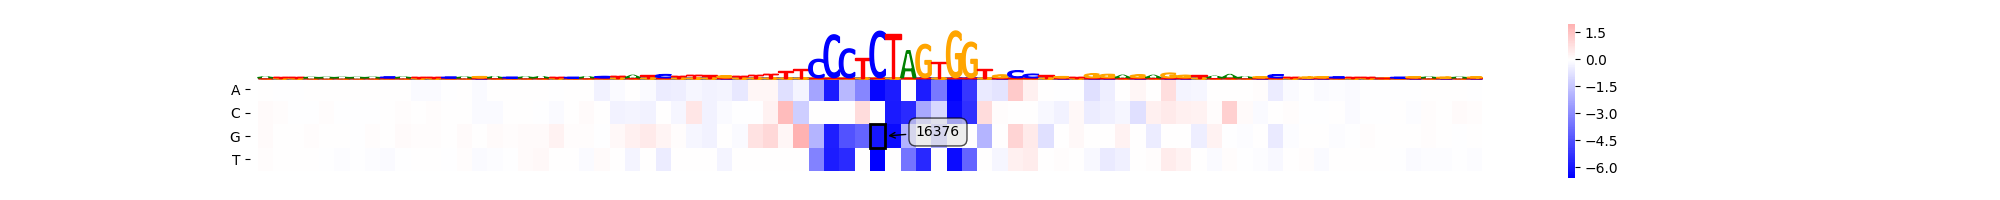

In [25]:
from IPython.display import Image
Image(filename=plot_file)